# NLP Disaster Tweets Kaggle Competition

## Problem Description

Twitter is a crucial communication platform during emergencies, where people often report disasters in real-time. However, distinguishing between tweets that genuinely report disasters and those that use disaster-related language metaphorically is challenging for machines. The goal of this competition is to build a machine learning model that predicts whether a tweet is about a real disaster or not.

### Dataset Details

The dataset consists of approximately 10,000 tweets, each labeled as either disaster-related (1) or not (0). Alongside the text, the dataset provides additional metadata, including:
- **Keyword**: A specific word from the tweet (optional).
- **Location**: Where the tweet originated (optional).

### Competition Objective

The task is to classify tweets as disaster-related (1) or not (0). Submissions are evaluated using the F1-score, which balances precision and recall to assess model performance.

This notebook is available at below git repo:
https://github.com/himanshudongre/NLP-Disaster-Tweets.git

### Files in the Dataset
1. `train.csv`: Contains labeled tweets for training.
2. `test.csv`: Contains unlabeled tweets for prediction.
3. `sample_submission.csv`: Template for submitting predictions.

The dataset is available at: https://www.kaggle.com/competitions/nlp-getting-started/data

### Evaluation Metric: F1-Score
The F1-score is defined as:

$$
F1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
$$

Where:

$$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{TP} + \text{False Positives (FP)}}
$$

$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{TP} + \text{False Negatives (FN)}}
$$


Let’s begin by exploring and analyzing the dataset.

## Exploratory Data Analysis (EDA)

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load datasets
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

# Display basic information about the training data
print("Training Data Info:")
print(train_data.info())
print("\nTraining Data Head:")
print(train_data.head())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

Training Data Head:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4      

In [2]:
# Check for missing values
print("\nMissing Values in Training Data:")
print(train_data.isnull().sum())

print("\nMissing Values in Test Data:")
print(test_data.isnull().sum())


Missing Values in Training Data:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing Values in Test Data:
id             0
keyword       26
location    1105
text           0
dtype: int64


**Observation:**

1. The `keyword` column has 61 missing values in the training dataset and 26 in the test dataset. This indicates that a small portion of tweets lacks specific keywords, though the `text` column remains informative for these cases.
2. The `location` column has significant missing values (2533 in training and 1105 in test). While locations may provide context, their utility is limited due to high sparsity.
3. The `text` column has no missing values, ensuring we have complete textual data for analysis and modeling.
4. The `target` column in the training data is fully populated, providing reliable labels for model training.

Instead of ignoring these rows, its better to mark them as unknown.This will help the model learn for cases where certain keywords or location is not present.

In [3]:
# Fill missing values without using inplace to avoid warnings
train_data = train_data.copy()
test_data = test_data.copy()

train_data['keyword'] = train_data['keyword'].fillna('unknown')
test_data['keyword'] = test_data['keyword'].fillna('unknown')

train_data['location'] = train_data['location'].fillna('unknown')
test_data['location'] = test_data['location'].fillna('unknown')

# Print updated missing values count
print("\nUpdated Missing Values in Training Data:")
print(train_data.isnull().sum())

print("\nUpdated Missing Values in Test Data:")
print(test_data.isnull().sum())


Updated Missing Values in Training Data:
id          0
keyword     0
location    0
text        0
target      0
dtype: int64

Updated Missing Values in Test Data:
id          0
keyword     0
location    0
text        0
dtype: int64


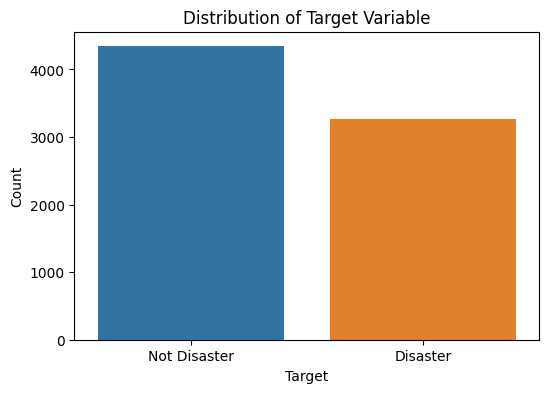

In [4]:
# Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'])
plt.show()

**Observations:**
1. The dataset is slightly imbalanced, with more non-disaster tweets than disaster tweets.
2. This imbalance could lead to biased predictions toward the majority class.
3. To mitigate this, we will focus on metrics like F1-score to ensure balanced evaluation across both classes.

While there is slight class imbalance, I think this is also indicative of real world data where there will be more non-disaster tweets as compared to disaster related tweets. So I am not planning to address this imbalance by oversampling.

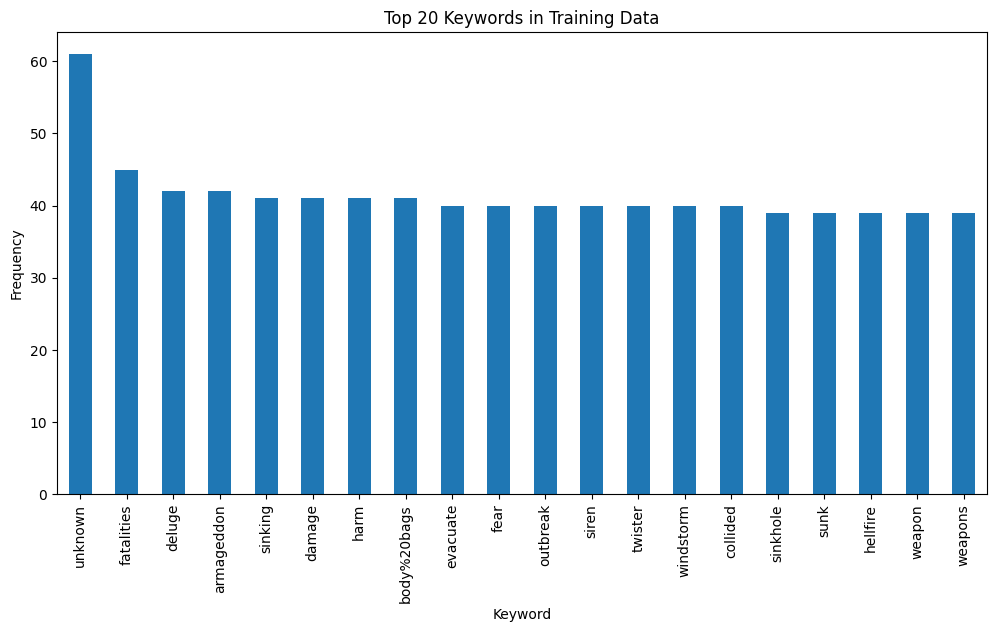

In [5]:
# Distribution of keywords
plt.figure(figsize=(12, 6))
train_data['keyword'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Keywords in Training Data')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.show()

**Observations:**
1. The top 20 keywords include terms strongly associated with disasters, such as "fatalities," "fear," and "damage"
2. These keywords provide valuable features for the model to identify disaster-related tweets.
3. The `unknown` keyword, used as a placeholder for missing values, appears frequently, indicating a substantial number of tweets without specific keywords.

In [6]:
# Check for unique and missing keywords
unique_keywords = train_data['keyword'].nunique()
missing_keywords = train_data['keyword'].isnull().sum()
print(f"Unique Keywords: {unique_keywords}")
print(f"Missing Keywords: {missing_keywords}")

Unique Keywords: 222
Missing Keywords: 0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


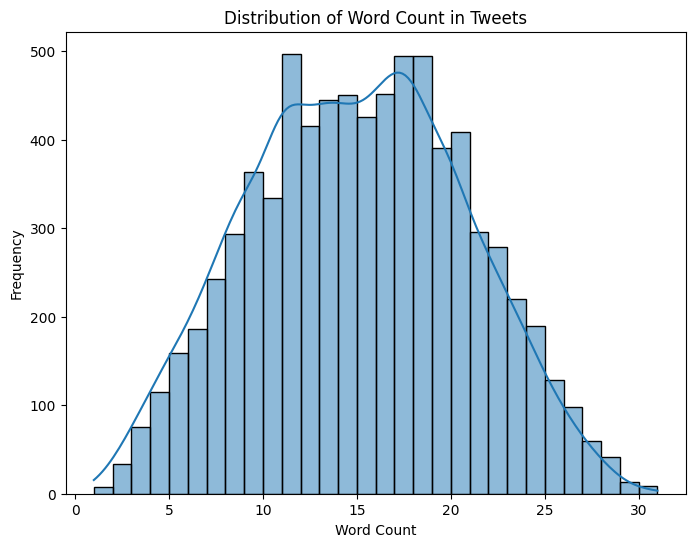


Word Count Statistics:
count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: word_count, dtype: float64


In [7]:
# Analyze the text data
# Count the number of words in each tweet
train_data['word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8, 6))
sns.histplot(train_data['word_count'], bins=30, kde=True)
plt.title('Distribution of Word Count in Tweets')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Print basic statistics of word count
print("\nWord Count Statistics:")
print(train_data['word_count'].describe())

In [8]:
# preprocessing: Cleaning tweets
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace
    return text

# Apply cleaning function to the text column
train_data['cleaned_text'] = train_data['text'].apply(clean_text)

# Display some cleaned text examples
print("\nOriginal and Cleaned Text Examples:")
print(train_data[['text', 'cleaned_text']].head())


Original and Cleaned Text Examples:
                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                        cleaned_text  
0  our deeds are the reason of this earthquake ma...  
1              forest fire near la ronge sask canada  
2  all residents asked to shelter in place are be...  
3  people receive wildfires evacuation orders in ...  
4  just got sent this photo from ruby alaska as s...  


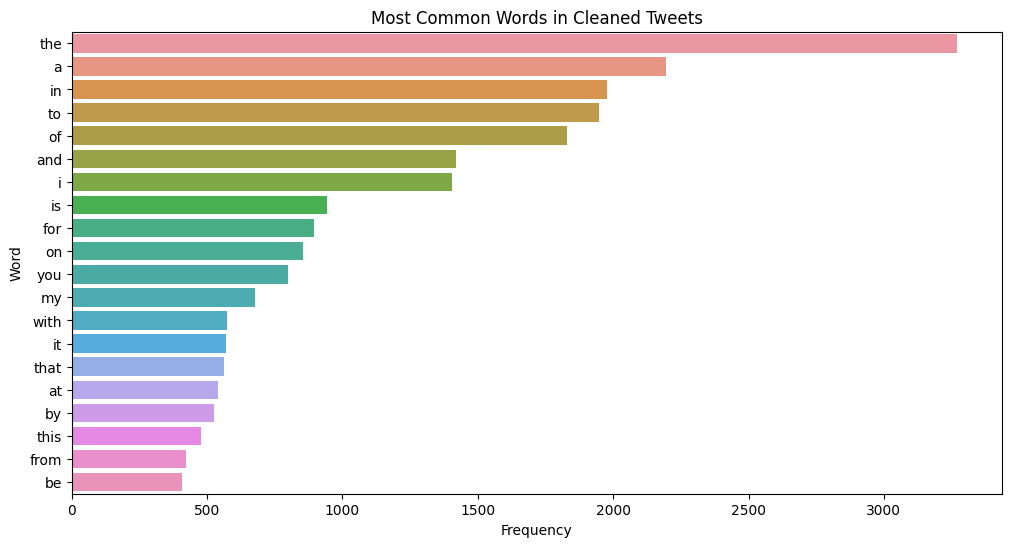

In [9]:
# Inspecting word frequencies
from collections import Counter
word_counts = Counter(" ".join(train_data['cleaned_text']).split())
most_common_words = word_counts.most_common(20)

# Visualizing most common words
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
plt.figure(figsize=(12, 6))
sns.barplot(data=common_words_df, x='Frequency', y='Word')
plt.title('Most Common Words in Cleaned Tweets')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


Top 10 Locations in Training Data:
location
unknown            2533
USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Name: count, dtype: int64


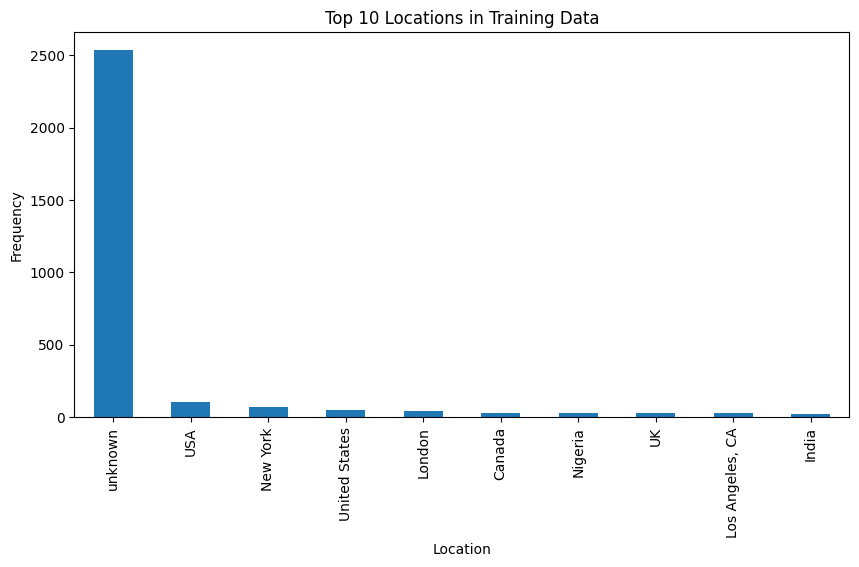

In [10]:
# Location analysis
location_counts = train_data['location'].value_counts().head(10)
print("\nTop 10 Locations in Training Data:")
print(location_counts)

plt.figure(figsize=(10, 5))
location_counts.plot(kind='bar')
plt.title('Top 10 Locations in Training Data')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.show()

## Model Building and Architecture

In [11]:
# Import necessary libraries for model building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define constants
MAX_VOCAB_SIZE = 20000  # Maximum number of unique words to keep
MAX_SEQUENCE_LENGTH = 100  # Maximum length of sequences after padding
EMBEDDING_DIM = 100  # Dimensionality of word embeddings

In [12]:
# Prepare the text data for modeling
# Tokenization and sequence padding
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['cleaned_text'])
sequences = tokenizer.texts_to_sequences(train_data['cleaned_text'])
word_index = tokenizer.word_index

print(f"Found {len(word_index)} unique tokens.")

padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

Found 16900 unique tokens.


In [13]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, train_data['target'], test_size=0.2, random_state=42
)

### Model Architecture

We start with the below layers for our baseline model architecutre.

1. **Embedding Layer**: 
   - Converts text data into dense vector representations of fixed size.
   - Captures semantic relationships between words, which are crucial for natural language processing tasks.

2. **Bidirectional LSTM**:
   - Long Short-Term Memory (LSTM) networks are effective for capturing long-term dependencies in sequential data.
   - The bidirectional structure allows the model to learn from both past and future contexts in the text, improving understanding in tweets where word order matters.

3. **Dropout Layers**:
   - Dropout layers are used to prevent overfitting by randomly setting a fraction of input units to zero during training.
   - This ensures the model generalizes better to unseen data.

4. **Dense Layers**:
   - Fully connected layers condense the learned features into predictions.
   - The dense layer with a `relu` activation helps model complex relationships, while the final dense layer with a `sigmoid` activation outputs probabilities for binary classification.

5. **Sigmoid Activation**:
   - Used in the output layer for binary classification tasks, as it outputs probabilities between 0 and 1.

### Reasoning:

- **Textual Nature of Tweets**:
  - Tweets are short and often noisy text sequences, making RNN-based architectures like LSTM particularly suitable for processing and understanding their context.

- **Feature Learning**:
  - The bidirectional LSTMs ensure better context comprehension, enabling the model to capture dependencies from both directions (past and future).

- **Regularization**:
  - Dropout layers help mitigate overfitting, especially since the dataset size is relatively small.

- **Modularity and Flexibility**:
  - This architecture is modular, making it easy to experiment with additional layers, hyperparameters, or optimizations to further enhance performance.


In [14]:
# Build the sequential neural network
baseline_model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
baseline_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model
history_baseline = baseline_model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 225ms/step - accuracy: 0.6135 - loss: 0.6538 - val_accuracy: 0.7978 - val_loss: 0.4595
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.8666 - loss: 0.3523 - val_accuracy: 0.7951 - val_loss: 0.4804
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 22s 226ms/step - accuracy: 0.9268 - loss: 0.2192 - val_accuracy: 0.7853 - val_loss: 0.4959
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - accuracy: 0.9555 - loss: 0.1402 - val_accuracy: 0.7728 - val_loss: 0.6210
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 236ms/step - accuracy: 0.9709 - loss: 0.0951 - val_accuracy: 0.7820 - val_loss: 0.5688


In [16]:
# Evaluate the model on validation data
val_predictions = (baseline_model.predict(X_val) > 0.5).astype("int32")
print("\nClassification Report on Validation Data:")
print(classification_report(y_val, val_predictions))

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step

Classification Report on Validation Data:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       874
           1       0.74      0.74      0.74       649

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523



In [17]:
# Visualize training history for the baseline model
def plot_training_history(history_baseline, title="Model Training History"):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history_baseline.history['accuracy'], label='Training Accuracy')
    plt.plot(history_baseline.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history_baseline.history['loss'], label='Training Loss')
    plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

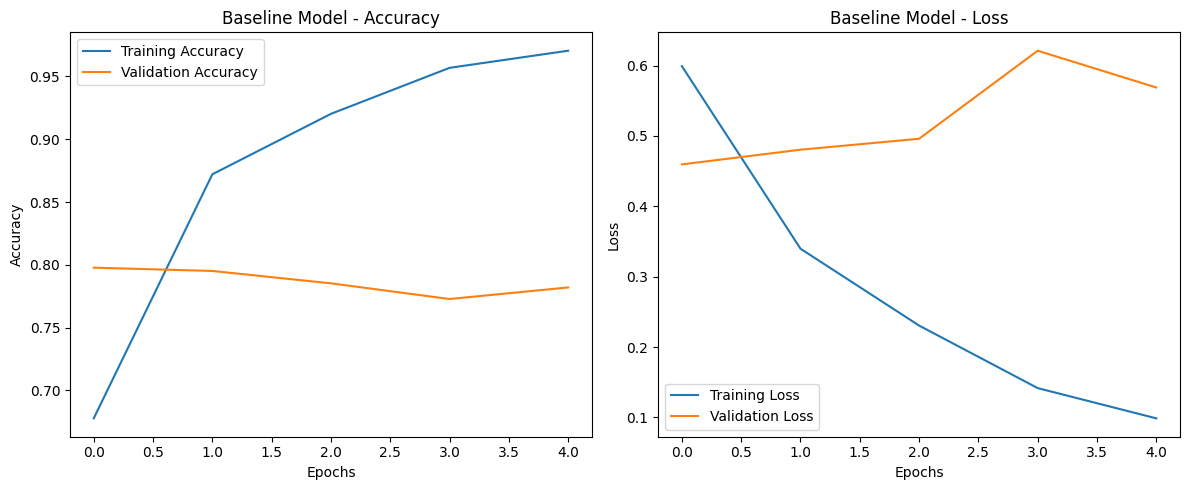

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
Baseline Model Validation F1 Score: 0.7438


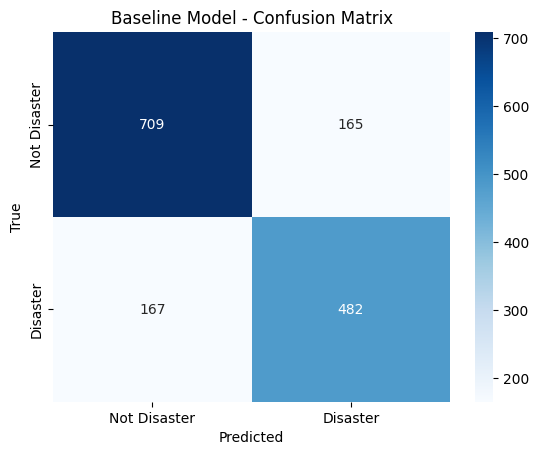

In [18]:
# Plot baseline model results
plot_training_history(history_baseline, title="Baseline Model")

# Evaluate the baseline model
val_predictions_baseline = (baseline_model.predict(X_val) > 0.5).astype("int32")
baseline_f1 = f1_score(y_val, val_predictions_baseline)
print(f"Baseline Model Validation F1 Score: {baseline_f1:.4f}")

# Confusion matrix for the baseline model
cm_baseline = confusion_matrix(y_val, val_predictions_baseline)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Disaster', 'Disaster'], yticklabels=['Not Disaster', 'Disaster'])
plt.title('Baseline Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Observations:**
1. **Accuracy:**
   - Training accuracy steadily improves, while validation accuracy plateaus after a few epochs.
   - The small gap between training and validation accuracy suggests a reasonable fit, but slight overfitting is observed.
2. **Loss:**
   - Training loss consistently decreases, while validation loss increases, clearly showing signs of overfitting.
3. **Prediction Errors:**
   - The model misclassified:
     - **167 disaster tweets** as non-disaster (false negatives).
     - **165 non-disaster tweets** as disaster (false positives).

Now lets make some changes to the model architecture to see if we can do better.

#### Key Changes from Baseline to Enhanced Model

1. **Switch from LSTM to GRU**:
   - **Change**: Replaced Bidirectional LSTMs with Bidirectional GRUs.
   - **Reasoning**: GRUs are computationally more efficient and sufficient for short sequences like tweets, improving training speed without compromising performance.

2. **Attention Layer**:
   - **Change**: Added after the first Bidirectional GRU.
   - **Reasoning**: Focuses on the most relevant parts of the text, reducing false positives observed in the baseline model.

3. **Hyperparameter Tuning**:
   - **Change**: Systematic tuning of RNN units, learning rate, and batch size.
   - **Reasoning**: Ensures the enhanced model is optimized for the task, given the architectd Attention).

4. **Dropout Regularization**:
   - **Change**: Retained Dropout layers after GRUs and Dense layers with a 0.3 dropout rate.
   - **Reasoning**: Prevents overfitting, ensuring better generalization as observed in the baseline model.

5. **Sigmoid Output Layer**:
   - **Change**: Retained Sigmoid output layer.
   - **Reasoning**: Suitable for binary classification, producing probabilities for disaster (1) r non-disaster (0).
 non-disaster (0).



In [19]:
# Define the enhanced model architecture
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional, Attention, Input
from tensorflow.keras.models import Model

def create_model(optimizer='adam', rnn_units=64):
    # Input layer
    input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))
    
    # Embedding layer
    x = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_layer)
    
    # First Bidirectional GRU layer
    x = Bidirectional(GRU(rnn_units, return_sequences=True))(x)
    
    # Attention Layer
    attention_output = Attention()([x, x])
    
    # Dropout for regularization
    x = Dropout(0.3)(attention_output)
    
    # Second Bidirectional GRU layer
    x = Bidirectional(GRU(rnn_units // 2))(x)
    
    # Dropout for regularization
    x = Dropout(0.3)(x)
    
    # Dense Layer
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.3)(x)
    
    # Output Layer
    output_layer = Dense(1, activation="sigmoid")(x)
    
    # Define the model
    enhanced_model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    enhanced_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    
    return enhanced_model


Training Enhanced Model with rnn_units=32 and learning_rate=0.001
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 193ms/step - accuracy: 0.5529 - loss: 0.6883 - val_accuracy: 0.5739 - val_loss: 0.6806
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - accuracy: 0.5696 - loss: 0.6831 - val_accuracy: 0.7492 - val_loss: 0.5337
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 178ms/step - accuracy: 0.8081 - loss: 0.4592 - val_accuracy: 0.8024 - val_loss: 0.4839
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - accuracy: 0.9188 - loss: 0.2480 - val_accuracy: 0.7932 - val_loss: 0.5092
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 184ms/step - accuracy: 0.9625 - loss: 0.1447 - val_accuracy: 0.7866 - val_loss: 0.6465
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step
Enhanced Model F1 Score: 0.7490

Training Enhanced Model with rnn_units=32 and learning_rate=0.0005
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 191ms/step - accuracy: 0.5599 - loss: 0.6869 - val_accuracy: 0.5739 - val_loss: 0.6816
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 186ms/step - accuracy: 0.5628 - loss: 0.6840 - val_accuracy: 0.5739 - val_loss: 0.6770
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 178ms/step - accuracy: 0.6071 - loss: 0.6577 - val_accuracy: 0.7649 - val_loss: 0.4987
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 186ms/step - accuracy: 0.8369 - loss: 0.4156 - val_accuracy: 0.7938 - val_loss: 0.4692
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 182ms/step - accuracy: 0.8985 - loss: 0.2994 - val_accuracy: 0.7669 - val_loss: 0.5714
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
Enhanced Model F1 Score: 0.7488

Training Enhanced Model with rnn_units=64 and learning_rate=0.001


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 244ms/step - accuracy: 0.5658 - loss: 0.6857 - val_accuracy: 0.5739 - val_loss: 0.6827
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - accuracy: 0.5663 - loss: 0.6817 - val_accuracy: 0.7406 - val_loss: 0.5240
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.8115 - loss: 0.4503 - val_accuracy: 0.7938 - val_loss: 0.4581
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 239ms/step - accuracy: 0.9162 - loss: 0.2499 - val_accuracy: 0.7905 - val_loss: 0.5450
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 242ms/step - accuracy: 0.9562 - loss: 0.1536 - val_accuracy: 0.7649 - val_loss: 0.6374
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step
Enhanced Model F1 Score: 0.7221

Training Enhanced Model with rnn_units=64 and learning_rate=0.0005
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 249ms/step - accuracy: 0.5551 - loss: 0.6888 - val_accuracy: 0.5739 - val_loss: 0.6828
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - accuracy: 0.5756 - loss: 0.6840 - val_accuracy: 0.5739 - val_loss: 0.6791
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - accuracy: 0.5781 - loss: 0.6777 - val_accuracy: 0.7525 - val_loss: 0.5823
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 232ms/step - accuracy: 0.7865 - loss: 0.5148 - val_accuracy: 0.7932 - val_loss: 0.4689
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 240ms/step - accuracy: 0.8652 - loss: 0.3525 - val_accuracy: 0.7919 - val_loss: 0.5037
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step
Enhanced Model F1 Score: 0.7190

Training Enhanced Model with rnn_units=128 and learning_rate=0.001
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 61s 546ms/step - accuracy: 0.5652 - loss: 0.6843 - val_accuracy: 0.5739 - val_loss: 0.6794
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 509ms/step - accuracy: 0.6278 - loss: 0.6431 - val_accuracy: 0.7853 - val_loss: 0.4851
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 510ms/step - accuracy: 0.8403 - loss: 0.3992 - val_accuracy: 0.7997 - val_loss: 0.4501
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 50s 516ms/step - accuracy: 0.9149 - loss: 0.2508 - val_accuracy: 0.7932 - val_loss: 0.5531
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 50s 518ms/step - accuracy: 0.9498 - loss: 0.1655 - val_accuracy: 0.7892 - val_loss: 0.6340
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step
Enhanced Model F1 Score: 0.7313

Training Enhanced Model with rnn_units=128 and learning_rate=0.0005
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 527ms/step - accuracy: 0.5653 - loss: 0.6848 - val_accuracy: 0.5739 - val_loss: 0.6815
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 50s 520ms/step - accuracy: 0.5740 - loss: 0.6821 - val_accuracy: 0.5739 - val_loss: 0.6753
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 50s 521ms/step - accuracy: 0.6188 - loss: 0.6499 - val_accuracy: 0.7630 - val_loss: 0.5005
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 509ms/step - accuracy: 0.8342 - loss: 0.4127 - val_accuracy: 0.7886 - val_loss: 0.5029
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 515ms/step - accuracy: 0.8972 - loss: 0.2835 - val_accuracy: 0.7991 - val_loss: 0.5269
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step
Enhanced Model F1 Score: 0.7177


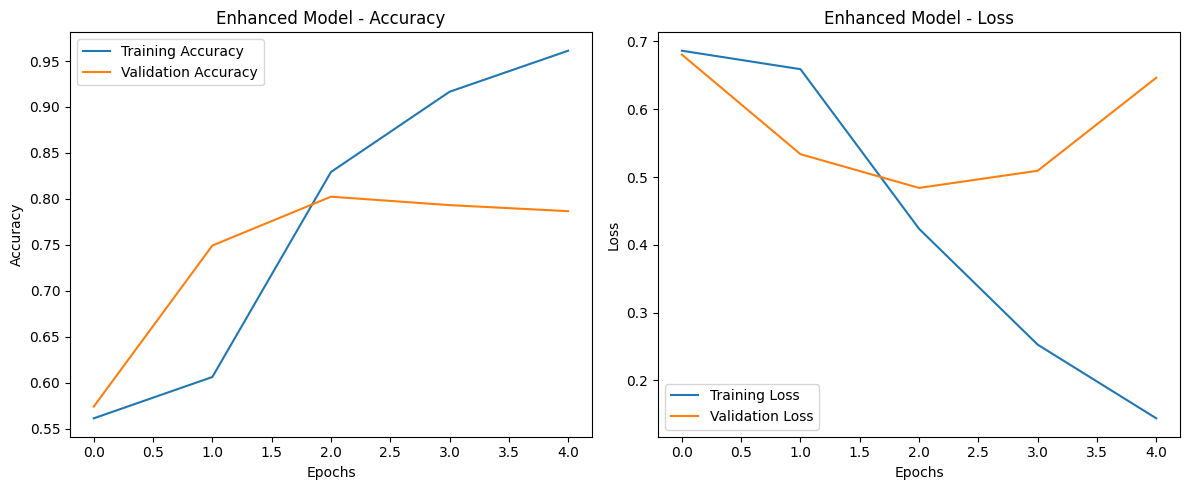


Best Hyperparameters: {'rnn_units': 32, 'learning_rate': 0.001}
Best Validation F1 Score: 0.7490


In [21]:
# Import EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Hyperparameter tuning for the enhanced model
best_f1 = 0
best_params = {}
for rnn_units in [32, 64, 128]:
    for learning_rate in [0.001, 0.0005]:
        print(f"\nTraining Enhanced Model with rnn_units={rnn_units} and learning_rate={learning_rate}")
        optimizer = Adam(learning_rate=learning_rate)
        enhanced_model = create_model(optimizer=optimizer, rnn_units=rnn_units)
        
        history_enhanced = enhanced_model.fit(
            X_train, y_train,
            epochs=5,
            batch_size=64,
            validation_data=(X_val, y_val),
            verbose=1,
            callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
        )
        
        val_predictions_enhanced = (enhanced_model.predict(X_val) > 0.5).astype("int32")
        f1 = f1_score(y_val, val_predictions_enhanced)
        print(f"Enhanced Model F1 Score: {f1:.4f}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_params = {'rnn_units': rnn_units, 'learning_rate': learning_rate}
            best_enhanced_model = enhanced_model
            best_enhanced_history = history_enhanced

# Plot enhanced model results
plot_training_history(best_enhanced_history, title="Enhanced Model")

print("\nBest Hyperparameters:", best_params)
print(f"Best Validation F1 Score: {best_f1:.4f}")

In [22]:
# Final evaluation for the enhanced model
print("\nBest Hyperparameters for Enhanced Model:", best_params)
print(f"Best Enhanced Model Validation F1 Score: {best_f1:.4f}")


Best Hyperparameters for Enhanced Model: {'rnn_units': 32, 'learning_rate': 0.001}
Best Enhanced Model Validation F1 Score: 0.7490


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


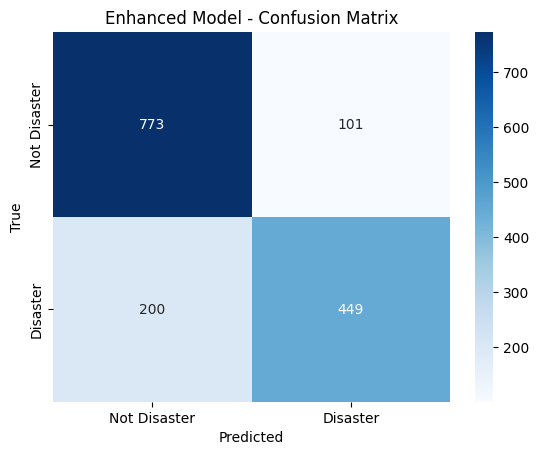

In [23]:
# Confusion matrix for the enhanced model
cm_enhanced = confusion_matrix(y_val, (best_enhanced_model.predict(X_val) > 0.5).astype("int32"))
sns.heatmap(cm_enhanced, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Disaster', 'Disaster'], yticklabels=['Not Disaster', 'Disaster'])
plt.title('Enhanced Model - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

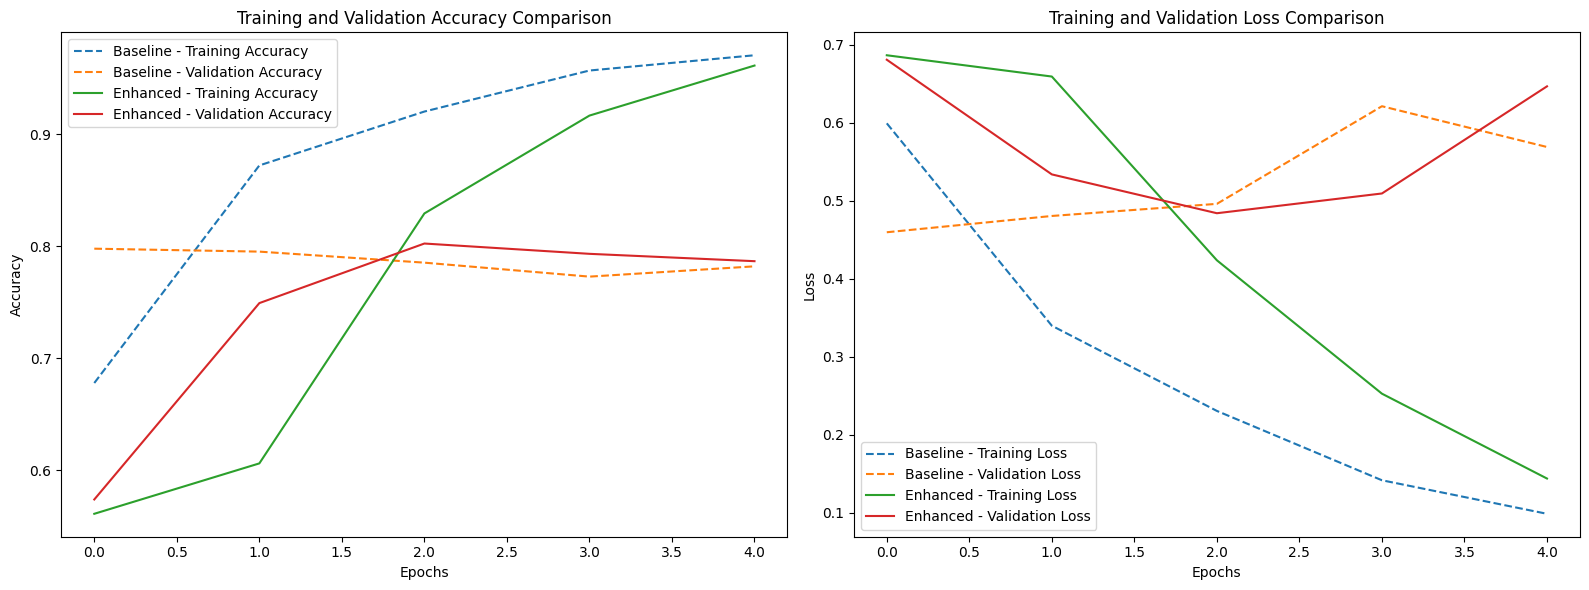

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


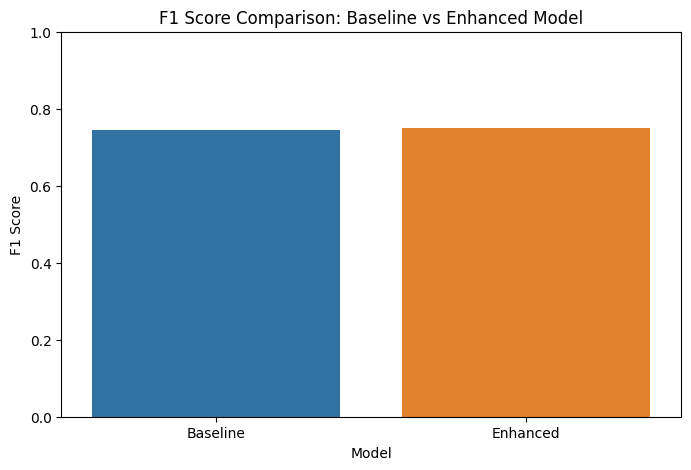

In [24]:
# Compare training histories: Accuracy and Loss
def compare_training_histories(history_baseline, best_enhanced_history):
    plt.figure(figsize=(16, 6))
    
    # Accuracy comparison
    plt.subplot(1, 2, 1)
    plt.plot(history_baseline.history['accuracy'], label='Baseline - Training Accuracy', linestyle='--')
    plt.plot(history_baseline.history['val_accuracy'], label='Baseline - Validation Accuracy', linestyle='--')
    plt.plot(best_enhanced_history.history['accuracy'], label='Enhanced - Training Accuracy')
    plt.plot(best_enhanced_history.history['val_accuracy'], label='Enhanced - Validation Accuracy')
    plt.title('Training and Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss comparison
    plt.subplot(1, 2, 2)
    plt.plot(history_baseline.history['loss'], label='Baseline - Training Loss', linestyle='--')
    plt.plot(history_baseline.history['val_loss'], label='Baseline - Validation Loss', linestyle='--')
    plt.plot(best_enhanced_history.history['loss'], label='Enhanced - Training Loss')
    plt.plot(best_enhanced_history.history['val_loss'], label='Enhanced - Validation Loss')
    plt.title('Training and Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Compare the histories
compare_training_histories(history_baseline, best_enhanced_history)

# Add F1 score comparison in a bar chart
f1_scores = {'Baseline': baseline_f1, 'Enhanced': best_f1}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()))
plt.title('F1 Score Comparison: Baseline vs Enhanced Model')
plt.ylabel('F1 Score')
plt.xlabel('Model')
plt.ylim(0, 1)  # Set y-axis range to represent F1 Score scale (0 to 1)
plt.show()

In [25]:
# Load test data and preprocess
test_sequences = tokenizer.texts_to_sequences(test_data['text'].apply(clean_text))
padded_test_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Use the best enhanced model to predict
test_predictions = (best_enhanced_model.predict(padded_test_sequences) > 0.5).astype("int32")

# Create a submission dataframe
submission = pd.DataFrame({
    'id': test_data['id'],
    'target': test_predictions.flatten()  # Flatten to make it a single column
})

# Save the submission file
submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created!")

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
Submission file 'submission.csv' created!


### Conclusion

1. **Performance Comparison:**
   - The **enhanced model** achieved a slightly higher **F1-score** compared to the baseline model, demonstrating better overall performance in balancing precision and recall.
   - The **validation accuracy** of the enhanced model is also higher than that of the baseline model, indicating improved generalization to unseen data.

2. **Training and Validation:**
   - The enhanced model exhibits consistent improvement in both training and validation accuracy over epochs.
   - While the enhanced model's validation loss fluctuates slightly after epoch 2, its higher validation accuracy suggests that it generalizes better than the baseline model.

3. **Impact of Architectural Changes:**
   - The addition of the **Attention layer** in the enhanced model likely contributed to its improved performance by enabling it to focus on the most relevant parts of disaster-related tweets.
   - The use of **GRU layers** instead of LSTMs ensured computational efficiency without compromising the model's ability to capture sequential patterns.

4. **Key Observations:**
   - The **enhanced model** outperformed the baseline in both **F1-score** and **validation accuracy**, making it more effective for disaster tweet classification.
   - The baseline model remains competitive due to its simplicity and smoother training and validation loss curves.
     
5. **Future Improvments:**
   - Further stabilize the enhanced model's validation loss through advanced regularization techniques, such as L2 regularization or additional Dropout layers.
   - Experiment with threshold tuning to improve the precision-recall tradeoff for disaster tweets.
   - Integrate pre-trained embeddings (e.g. GloVe or FastText) for better feature representations and enhanced performance.

The enhanced model demonstrates its capability to generalize better and handle class imbalances more effectively, making it a promising improvement over the baseline.